In [1]:
import numpy as np
from pygeotools import *
from pygeopinn import *

In [2]:
pygeo = pygeotools()

pygeotools was initialized with `verbose=True`.


In [3]:
pygeo.loadModel("covobs", "covobs_hdf5", "covobs.hdf5")

pygeo.setGrid("1deg")

context = {
    "r": pygeo.constants["rCore"],
    "lmax": 13
}

MF = pygeo.addMeasure("covobs", "MF", context)
SV = pygeo.addMeasure("covobs", "SV", context)

13


In [4]:
pinn = pygeopinn(nb_layers=5, nb_nodes=64, nb_inputs=2, nb_outputs=2)

In [5]:
_, (thetas, phis) = pygeo.getCurrentGrid()

thetas = np.rad2deg(thetas)
phis = np.rad2deg(phis)

In [6]:
theta_min, theta_max = 10, 30
phi_min, phi_max = 10, 30

idx_theta_min = np.argmin(np.abs(thetas - theta_min))
idx_theta_max = np.argmin(np.abs(thetas - theta_max))
idx_phi_min = np.argmin(np.abs(phis - phi_min))
idx_phi_max = np.argmin(np.abs(phis - phi_max))

In [7]:
Br = pygeo.selectFromMeasure("covobs", MF, options={"time": 2020, "component": "r"})
dBrdt = pygeo.selectFromMeasure("covobs", SV, options={"time": 2020, "component": "r"})
times = pygeo.selectFromQuantity("covobs", "times")

In [8]:
pinn.set_grid(thetas[idx_theta_min:idx_theta_max+1], phis[idx_phi_min:idx_phi_max+1])

In [9]:
pinn.add("Br", Br[idx_theta_min:idx_theta_max+1,idx_phi_min:idx_phi_max+1])
pinn.add("dBrdt", dBrdt[idx_theta_min:idx_theta_max+1,idx_phi_min:idx_phi_max+1])
pinn.add("times", times)

In [ ]:
pinn.init()

pinn.train(nb_reals=1, nb_epochs=1000, algo="adam")

Epoch 0: L1 = 4469611.5, L2 = 2.9746788365869747e-10


C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\autograd\graph.py:824: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [441, 1], strides() = [1, 0]
param.sizes() = [441, 1], strides() = [1, 0] (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch/csrc/autograd/functions/accumulate_grad.h:218.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 100: L1 = 26999.5390625, L2 = 2.9698596335947514e-05
Epoch 200: L1 = 13061.0263671875, L2 = 2.4027203835430555e-05
Epoch 300: L1 = 12002.3740234375, L2 = 2.336470970476512e-05
Epoch 400: L1 = 11437.34765625, L2 = 2.2936415916774422e-05
Epoch 500: L1 = 11215.15625, L2 = 2.3468741346732713e-05
Epoch 600: L1 = 10661.6171875, L2 = 2.239362584077753e-05
Epoch 700: L1 = 34527.6015625, L2 = 2.0578911062330008e-05
Epoch 800: L1 = 9985.71875, L2 = 2.170752668462228e-05
Epoch 900: L1 = 9628.65625, L2 = 2.124075763276778e-05
Epoch 1000: L1 = 9330.9208984375, L2 = 2.0833020244026557e-05
Epoch 1100: L1 = 8944.5888671875, L2 = 2.0167452021269128e-05
Epoch 1200: L1 = 11318.076171875, L2 = 2.0082354240003042e-05
Epoch 1300: L1 = 8346.115234375, L2 = 1.9205193893867545e-05
Epoch 1400: L1 = 11715.7646484375, L2 = 1.8200173144578002e-05
Epoch 1500: L1 = 7792.6201171875, L2 = 1.86835623026127e-05
Epoch 1600: L1 = 26250.93359375, L2 = 2.007067269005347e-05
Epoch 1700: L1 = 7242.64501953125, L2 = 1.85

In [ ]:
pinn.train(nb_reals=1, nb_epochs=100, algo="lbfgs")

Epoch 0: Loss = 170.63157653808594
Epoch 100: Loss = 6.237304210662842
Epoch 200: Loss = 6.237304210662842
Epoch 300: Loss = 6.237304210662842
Epoch 400: Loss = 6.237304210662842
Epoch 500: Loss = 6.237304210662842
Epoch 600: Loss = 6.237304210662842
Epoch 700: Loss = 6.237304210662842
Epoch 800: Loss = 6.237304210662842
Epoch 900: Loss = 6.237304210662842


In [12]:
dBrdt_pred, uth_pred, uph_pred = pinn.results()

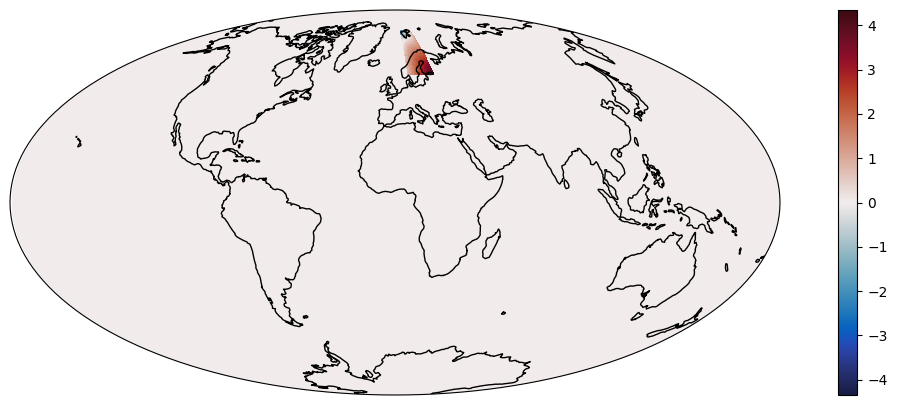

In [13]:
import cmocean
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

u_th_full = numpy.zeros((thetas.size, phis.size))
u_th_full[idx_theta_min:idx_theta_max+1,idx_phi_min:idx_phi_max+1] = uth_pred

latitudes = pygeo.convertThetasToLatitudes(thetas)
longitudes = pygeo.convertPhisToLongitudes(phis)

lat_grid, lon_grid = numpy.meshgrid(latitudes, longitudes, indexing="ij")

fig = plt.figure(figsize=(15,5))

# Set the projection to Hammer and add the axes
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Aitoff())

u_max = numpy.max(numpy.abs(u_th_full))

# Use `pcolormesh` to project the data onto the map
pcol = ax.pcolormesh(lon_grid, lat_grid, u_th_full, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-u_max, vmax=u_max)

# Add coastlines for context
ax.coastlines()

plt.colorbar(pcol)

In [ ]:
# Generating the patchwork